In [3]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
Tlist =[1.0]
clist = [cm.get_cmap("gnuplot")(float(i)/float(len(Tlist))) for i in range(len(Tlist))]
font={'family':'serif',
      # 'style':'italic',  # 斜体
      'weight':'normal',
      # 'color':'red',
      'size': 18
}

/tmp/ipykernel_892719/2950165697.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clist = [cm.get_cmap("gnuplot")(float(i)/float(len(Tlist))) for i in range(len(Tlist))]


In [4]:
def read_kernel(dirname):
    filename = os.path.join(dirname, "aveS0.dat")
    with open(filename,"r") as fp:
        fp.readline()
        fp.readline()
        fp.readline()
        s0CC,covs0CC = tuple([float(x) for x in fp.readline().split()])
        s0HfC,covs0HfC = tuple([float(x) for x in fp.readline().split()])
        s0HfHf,covs0HfHf = tuple([float(x) for x in fp.readline().split()])
    return s0CC, s0HfC, s0HfHf, covs0CC, covs0HfC, covs0HfHf

In [5]:
def read_lammpstrj(filedesc):
    # three comment lines
    for i in range(3): comment = filedesc.readline()
    # number of atoms
    natoms = int(filedesc.readline())

    # 1 comment line
    comment = filedesc.readline()
    # assume orthorombic cell
    cell = np.zeros(3,float)
    for i in range(3):
        # [cellmin, cellmax] = filedesc.readline().split()
        linec = filedesc.readline().split()
        cellmin = linec[0]
        cellmax = linec[1]
        cell[i] = float(cellmax) - float(cellmin)

    # 1 comment line
    comment = filedesc.readline()
    names = np.zeros(natoms,'U2')
    q = np.zeros((natoms,3),float)
    sq = np.zeros((natoms,3),float)

    for i in range(natoms):
        line = filedesc.readline().split();
        names[i] = line[1] # atom type
        q[i] = line[2:5] # wrapped atomic coordinates
        sq[i,0] = float(q[i,0])/cell[0] # scaled atomic coordinates
        sq[i,1] = float(q[i,1])/cell[1] # scaled atomic coordinates
        sq[i,2] = float(q[i,2])/cell[2] # scaled atomic coordinates
    return [cell, names, sq]

In [6]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian

In [7]:
import dpdata
num_Vc = np.arange(0.1,1.,0.05)
print(num_Vc)
num_Vlist=[(i,1-i) for i in num_Vc]
totalatom = 23328
c_A_list = []
c_B_list = []
Tlist = [1.]
Volume_list = []
for idx_T, T in enumerate(Tlist):
    c_A_list.append([])
    c_B_list.append([])
    Volume_list.append([])
    for idx_num_V, num_V in enumerate(num_Vlist):
        num_V1 = num_V[0]
        dirname = "binary/frac%.2f/"%(num_V1)
        filename = os.path.join(dirname, "thermo-lammps.dat")
        Volume_data = np.loadtxt(filename, skiprows=10007).T[6]
        Volume = np.mean(Volume_data)
        Volume_list[-1].append(Volume)
        conf = dpdata.System(os.path.join(dirname, "data.lj"), "lammps/lmp")
        c_A = conf["atom_numbs"][0]/Volume
        c_A_list[-1].append(c_A)
        c_B = conf["atom_numbs"][1]/Volume
        c_B_list[-1].append(c_B)

        
        print(int(np.ceil(totalatom*num_V1)), conf["atom_numbs"][0])
        # assert int(np.ceil(totalatom*num_V1)) == conf["atom_numbs"][0]
        # assert int(totalatom-np.ceil(totalatom*num_V1)) == conf["atom_numbs"][1]
c_A_list = np.array(c_A_list)
c_B_list = np.array(c_B_list)
Volume_list = np.array(Volume_list)

print(c_A_list)
print(c_B_list)
print(totalatom)
assert np.allclose(c_A_list+c_B_list, totalatom/Volume_list)

[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95]
2333 2333
3500 3500
4666 4666
5833 5832
6999 6999
8165 8165
9332 9332
10498 10498
11665 11664
12831 12831
13997 13997
15164 15164
16330 16330
17497 17497
18663 18663
19829 19829
20996 20996
22162 22162
[[0.08623743 0.12926033 0.17217579 0.2150202  0.25782012 0.30052131
  0.34318462 0.38574674 0.42822356 0.47068811 0.51302895 0.55537598
  0.59756185 0.63976958 0.68185041 0.72388607 0.76585956 0.80775236]]
[[0.77606292 0.73227826 0.68862937 0.64506061 0.60150661 0.55808998
  0.51470338 0.47143557 0.42822356 0.38506843 0.34200708 0.29900353
  0.25607702 0.21320777 0.1704352  0.12773601 0.08506308 0.04249794]]
23328


In [8]:
def cofactor(B):
    return (np.linalg.inv(B)).T * np.linalg.det(B)


In [9]:
def fillDmat(x, Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Dmat = np.eye(rank)
    for i in range(rank):
        for j in range(rank):
            if i != j:
                Dmat[i][j] += np.sqrt(x[j]/x[i])*(Smat[i][j])
            else:
                Dmat[i][j] += np.sqrt(x[j]/x[i])*(Smat[i][j]-1)
    return Dmat

def fillDmat_(x, Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Dmat = torch.eye(rank).to(torch.float64)
    for i in range(rank):
        for j in range(rank):
            if i != j:
                Dmat[i][j] += torch.sqrt(x[j]/x[i])*(Smat[i][j])
            else:
                Dmat[i][j] += torch.sqrt(x[j]/x[i])*(Smat[i][j]-1)
    return Dmat

In [10]:
def fillapproxGmat(Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Gmat = Smat/0.04-np.eye(rank,rank)/0.04
    return Gmat

def fillGmat_(c, Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Gmat = Smat-torch.eye(rank,rank).to(torch.float64)
    for i in range(rank):
        for j in range(rank):
            Gmat[i][j] /= torch.sqrt(c[i]*c[j])
    return Gmat

In [11]:
def fillBmat_(c, Gmat):
    assert Gmat.shape[0] == Gmat.shape[1] and len(Gmat.shape) == 2
    rank = Gmat.shape[0]  
    Bmat = torch.eye(rank,rank).to(torch.float64)
    for i in range(rank):
        for j in range(rank):
            if i == j:
                Bmat[i][j] = c[i]+c[i]*c[j]*Gmat[i][j]
            else:
                Bmat[i][j] = c[i]*c[j]*Gmat[i][j]
    return Bmat

In [12]:
def KBI_mu(c_, Smat_, elem=0):
    rank = c_.shape[0]
    Smat_ = Smat_.reshape(rank, rank)
    # print("            Smat = ", Smat_[0,0], Smat_[1,1], Smat_[0,1], Smat_[1,0])
    
    Gmat_ = fillGmat_(c_, Smat_)

    Kai_NPT_00_a = 1./(Smat_[0][0]-torch.sqrt(c_[0]/c_[1])*Smat_[0][1]) 
    Kai_NPT_11_a = 1./(Smat_[1][1]-torch.sqrt(c_[1]/c_[0])*Smat_[0][1]) 
    Kai_NPT_00_b = 1./(1.+c_[0]*(Gmat_[0][0]-Gmat_[0][1])) 
    Kai_NPT_11_b = 1./(1.+c_[1]*(Gmat_[1][1]-Gmat_[1][0])) 
    assert torch.allclose( Kai_NPT_00_a, Kai_NPT_00_b)
    assert torch.allclose( Kai_NPT_11_a, Kai_NPT_11_b)

    if elem == 0:
        return Kai_NPT_00_a
    elif elem == 1:
        return Kai_NPT_11_b

In [13]:
Kai_NPT_lnx_list = []
Kai_NPT_lnx1_list = []
std_Kai_NPT_lnx_list = []
s0CC_list = []
s0HfC_list = []
s0HfHf_list = []
Tlist = [1.]
for idx_T, T in enumerate(Tlist):
    Kai_NPT_lnx_list.append([])
    Kai_NPT_lnx1_list.append([])
    std_Kai_NPT_lnx_list.append([])
    s0CC_list.append([])
    s0HfC_list.append([])
    s0HfHf_list.append([])
    for idx_num_V, num_V in enumerate(num_Vlist):
        num_V1 = num_V[0]
        dirname = "binary/frac%.2f/"%(num_V1)
        s0CC, s0HfC, s0HfHf, cov_s0CC, cov_s0HfC, cov_s0HfHf = read_kernel(dirname)
        s0CC_list[-1].append(s0CC)
        s0HfC_list[-1].append(s0HfC)
        s0HfHf_list[-1].append(s0HfHf)

        x = num_V
        print("Number of C vacancies =", num_V1)
        print("Mole fraction of atoms in the system =",x)
        c_A = c_A_list[0][idx_num_V]
        c_B = c_B_list[0][idx_num_V]
        c = torch.tensor([c_A, c_B]).to(torch.float64).requires_grad_(False)
        print("Density of atoms in the system =",c)
        Smat = np.array([[s0CC, s0HfC], [s0HfC, s0HfHf]])
        std_Smat = np.sqrt(np.array([cov_s0CC, cov_s0HfC, cov_s0HfC, cov_s0HfHf]))
        # print("   std_Smat = ", std_Smat)
        varmat_Smat = np.outer(std_Smat, std_Smat)
        # print("varmat_Smat = ")
        # print(varmat_Smat)

        Smat_ = torch.from_numpy(Smat.reshape(-1)).to(dtype=torch.float64).requires_grad_()
        x_ = torch.tensor(x).to(torch.float64).requires_grad_(False)
        print("Volume = ", Volume_list[idx_T][idx_num_V])
        Kai_NPT_lnx_0 = KBI_mu(c, Smat_, 0)
        Kai_NPT_lnx_1 = KBI_mu(c, Smat_, 1)
        print("Kai_NPT_lnc = ", Kai_NPT_lnx_0.detach().numpy(), Kai_NPT_lnx_1.detach().numpy())
        jac = jacobian(KBI_mu, (c, Smat_.reshape(-1)))[1]
        # print("Jac = ")
        # print(jac)
        varmat_Smat_ = torch.from_numpy(varmat_Smat)
        varmat_KaiNPT_lnx = torch.matmul(torch.matmul(jac, varmat_Smat_), jac.T)

        
        # print("          var_KaiNPT_lnx = ", varmat_KaiNPT_lnx)
        std_KaiNPT_lnx = torch.sqrt(varmat_KaiNPT_lnx)
        # print("          std_KaiNPT_lnx = ", std_KaiNPT_lnx)
        Kai_NPT_lnx_list[-1].append(Kai_NPT_lnx_0.detach().numpy())
        Kai_NPT_lnx1_list[-1].append(Kai_NPT_lnx_1.detach().numpy())
        std_Kai_NPT_lnx_list[-1].append(std_KaiNPT_lnx.detach().numpy())

        print("\n")
        

Number of C vacancies = 0.1
Mole fraction of atoms in the system = (0.1, 0.9)
Density of atoms in the system = tensor([0.0862, 0.7761], dtype=torch.float64)
Volume =  27053.218907909213
Kai_NPT_lnc =  0.9995176442284776 0.9770830223629947




Number of C vacancies = 0.15000000000000002
Mole fraction of atoms in the system = (0.15000000000000002, 0.85)
Density of atoms in the system = tensor([0.1293, 0.7323], dtype=torch.float64)
Volume =  27077.138856828635
Kai_NPT_lnc =  0.9972430121750608 0.9766845257361192


Number of C vacancies = 0.20000000000000004
Mole fraction of atoms in the system = (0.20000000000000004, 0.7999999999999999)
Density of atoms in the system = tensor([0.1722, 0.6886], dtype=torch.float64)
Volume =  27100.209287771224
Kai_NPT_lnc =  0.9889771177040182 0.9684574177328895


Number of C vacancies = 0.25000000000000006
Mole fraction of atoms in the system = (0.25000000000000006, 0.75)
Density of atoms in the system = tensor([0.2150, 0.6451], dtype=torch.float64)
Volume =  27123.032566486705
Kai_NPT_lnc =  1.006530227738626 0.9866522266960537


Number of C vacancies = 0.30000000000000004
Mole fraction of atoms in the system = (0.30000000000000004, 0.7)
Density of atoms in the system = tensor([0.2578, 0.60

/tmp/ipykernel_892719/3193613552.py:47: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  varmat_KaiNPT_lnx = torch.matmul(torch.matmul(jac, varmat_Smat_), jac.T)


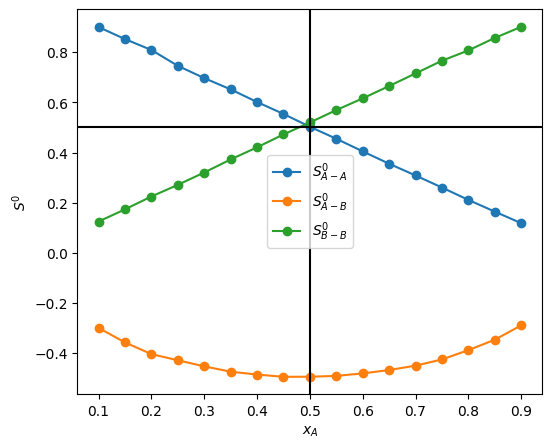

In [32]:
plt.rcParams["figure.figsize"] = (6,5)
xlist = num_Vc
plt.plot(xlist[:-1], s0CC_list[0][:-1], marker="o", label="$S^0_{A-A}$")
plt.plot(xlist[:-1], s0HfC_list[0][:-1], marker="o", label="$S^0_{A-B}$")
plt.plot(xlist[:-1], s0HfHf_list[0][:-1], marker="o", label="$S^0_{B-B}$")
plt.axhline(0.5, c="k")
plt.axvline(0.5, c="k")
plt.xlabel("$x_A$")
plt.ylabel("$S^0$")
plt.legend()

In [15]:
Kai_NPT_lnx_list[0] = np.array(Kai_NPT_lnx_list[0])
Kai_NPT_lnx1_list[0] = np.array(Kai_NPT_lnx1_list[0])


In [16]:

lnc = np.log(c_A_list).reshape(-1,1)
lnc1 = np.log(c_B_list).reshape(-1,1)
print(totalatom)
Volume_list = np.array(Volume_list)
print(Volume_list)
print(totalatom*np.arange(0.1, 1, 0.05)/Volume_list)
print(c_A_list)
print(totalatom*np.arange(0.95,0.05,-0.05)/Volume_list)
print(c_B_list)

print(lnc.reshape(-1))
print(lnc1.reshape(-1))

23328
[[27053.21890791 27077.13885683 27100.20928777 27123.03256649
  27146.83406699 27169.45385763 27192.36080362 27214.74745071
  27238.10891351 27260.08960848 27283.06088471 27304.02552909
  27327.71518228 27348.90913997 27371.10619078 27392.43224455
  27414.94783972 27436.62669986]]
[[0.08623003 0.12923079 0.17216103 0.2150202  0.25779802 0.30051395
  0.3431552  0.38573204 0.42822356 0.4706661  0.51302162 0.55534668
  0.59754721 0.63973301 0.68182849 0.72387876 0.76583038 0.80773778]]
[[0.08623743 0.12926033 0.17217579 0.2150202  0.25782012 0.30052131
  0.34318462 0.38574674 0.42822356 0.47068811 0.51302895 0.55537598
  0.59756185 0.63976958 0.68185041 0.72388607 0.76585956 0.80775236]]
[[0.81918533 0.77538473 0.73168439 0.68806465 0.64449504 0.60102791
  0.5576272  0.51430938 0.47104592 0.42787827 0.38476621 0.3417518
  0.29877361 0.2558932  0.2130714  0.17032442 0.1276384  0.08502503]]
[[0.77606292 0.73227826 0.68862937 0.64506061 0.60150661 0.55808998
  0.51470338 0.47143557 0.4

In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from scipy.integrate import quad
# kernel = 1.0 * RBF(length_scale=0.005, length_scale_bounds="fixed")
kernel = 1.0 * RBF(length_scale=1) +ConstantKernel()
gp = GaussianProcessRegressor(kernel=kernel)

gp.fit(lnc.reshape(-1,1), Kai_NPT_lnx_list[0].reshape(-1,1))
y_gp, std_y_gp = gp.predict(lnc.reshape(-1,1), return_std=True)



kernel = 1.0 * RBF(length_scale=1) +ConstantKernel()
gp1 = GaussianProcessRegressor(kernel=kernel)
gp1.fit(lnc1.reshape(-1,1), Kai_NPT_lnx1_list[0].reshape(-1,1))
y_gp1, std_y_gp1 = gp1.predict(lnc1.reshape(-1,1), return_std=True)

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


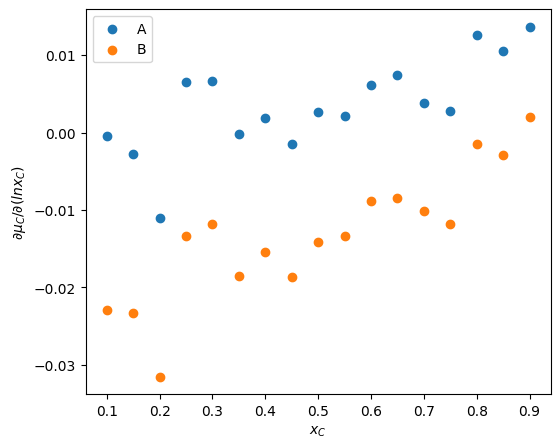

In [31]:
plt.rcParams["figure.figsize"] = (6,5)

plt.scatter(xlist[:-1], Kai_NPT_lnx_list[0][:-1]-1, marker="o", label="A")
# plt.scatter(xlist, y_gp-1, marker="*", label="A")

plt.scatter(xlist[:-1], Kai_NPT_lnx1_list[0][:-1]-1, marker="o", label="B")
# plt.scatter(xlist, y_gp1-1, marker="x", label="B")

plt.xlabel("$x_C$")
plt.ylabel("$\partial \mu_C/\partial (lnx_C)$")
plt.legend()

# plt.subplot(122)
# plt.scatter(x, Kai_NPT_lnx_list[0], marker="o", label="sample")
# plt.errorbar(x, Kai_NPT_lnx_list[0], order2_std_Kai_NPT_lnx_list[0], label="2nd order stderr")
# plt.xlabel("$x_C$")
# plt.ylabel("$\partial \mu_C/\partial (lnx_C)$")
# plt.legend()


[-2.450651   -2.04592682 -1.75923928 -1.53702328 -1.35549315 -1.2022366
 -1.06948673 -0.95257425 -0.84810988 -0.7535596  -0.66742301 -0.58810995
 -0.51489749 -0.44664721 -0.38294498 -0.32312127 -0.26675646 -0.21349975]
[-0.25352168 -0.31159471 -0.37305208 -0.43841099 -0.50831776 -0.58323507
 -0.66416451 -0.75197283 -0.84810988 -0.95433421 -1.07292384 -1.2072999
 -1.362277   -1.54548813 -1.7694001  -2.05778957 -2.46436214 -3.15829977]
Integrand
[-0.00048236 -0.00275699 -0.01102288  0.00653023  0.00666064 -0.0001527
  0.0018591  -0.00145058  0.00270261  0.00215211  0.00611167  0.00743617
  0.00388758  0.00274522  0.01264541  0.0105287   0.01368244  0.0020683 ]
[-0.02291698 -0.02331547 -0.03154258 -0.01334777 -0.01183457 -0.01846303
 -0.01538026 -0.01869138 -0.01409668 -0.01334489 -0.00881144 -0.00841429
 -0.01016547 -0.01177188 -0.00145508 -0.00290207  0.00209394 -0.00538712]
Integral cumsum
[-0.00065551 -0.00263076 -0.00312993 -0.00193266 -0.00143397 -0.00132071
 -0.00129682 -0.00123143

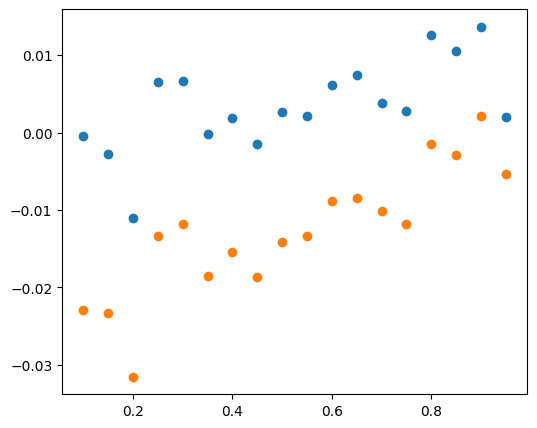

In [26]:
plt.rcParams["figure.figsize"] = (6,5)
from scipy.integrate import trapz
lnc1 = lnc1.reshape(-1)
lnc = lnc.reshape(-1)
print(lnc)
print(lnc1)


print("Integrand")
# print(y_gp-1)
print(Kai_NPT_lnx_list[0]-1)
# print(y_gp1-1)
print(Kai_NPT_lnx1_list[0]-1)

plt.scatter(xlist, y_gp-1)
plt.scatter(xlist, y_gp1-1)

integral_gp = np.cumsum([(y_gp[i]+y_gp[i+1]-2)/2*(lnc[i+1]-lnc[i]) for i in np.arange(len(lnc)-1)])
integral_gp1 = np.cumsum([(y_gp1[i]+y_gp1[i+1]-2)/2*(lnc1[i+1]-lnc1[i]) for i in range(len(lnc1)-1)])
print("Integral cumsum")
print(integral_gp)
print(integral_gp1)
# baseline = np.cumsum([-(lnc[i]+lnc[i-1])/2*(lnc[i]-lnc[i-1]) for i in range(len(lnc)-1,0, -1)])
# baseline1 = np.cumsum([-(lnc1[i]+lnc1[i+1])/2*(lnc1[i+1]-lnc1[i]) for i in range(len(lnc1)-1)])
# print("baseline")
# print(baseline)
# print(baseline1)
# 
# print("excess")
# print((integral_gp-baseline)-(integral_gp-baseline)[0])
# print((integral_gp1-baseline1)-(integral_gp1-baseline1)[0])


In [20]:
# integral by MC
'''
lnx = lnx.reshape(-1)
MCintegral_gp = [y_gp[0]]
MCintegral_gp_std = [0]
print(std_Kai_NPT_lnx_list)

for i in range(1, len(lnx)-1):
    min_lnx = lnx[0]
    max_lnx = lnx[i+1]
    area_lnx = (max_lnx-min_lnx)
    MC_x_samples = np.random.uniform(min_lnx, max_lnx, size=100*(i))
    MC_y_samples, std_MC_y_samples = gp.predict(MC_x_samples.reshape(-1,1), return_std=True)
    MC_y_average = np.mean(MC_y_samples.reshape(-1))
    MC_y_std = max(np.max(std_MC_y_samples.reshape(-1)), std_Kai_NPT_lnx_list[0][i])/np.sqrt(100*(i))
    MCintegral_gp.append(MC_y_average*(area_lnx))
    MCintegral_gp_std.append(MC_y_std*area_lnx)

MCintegral_gp = np.array(MCintegral_gp)
MCintegral_gp_std = np.array(MCintegral_gp_std)
'''


'\nlnx = lnx.reshape(-1)\nMCintegral_gp = [y_gp[0]]\nMCintegral_gp_std = [0]\nprint(std_Kai_NPT_lnx_list)\n\nfor i in range(1, len(lnx)-1):\n    min_lnx = lnx[0]\n    max_lnx = lnx[i+1]\n    area_lnx = (max_lnx-min_lnx)\n    MC_x_samples = np.random.uniform(min_lnx, max_lnx, size=100*(i))\n    MC_y_samples, std_MC_y_samples = gp.predict(MC_x_samples.reshape(-1,1), return_std=True)\n    MC_y_average = np.mean(MC_y_samples.reshape(-1))\n    MC_y_std = max(np.max(std_MC_y_samples.reshape(-1)), std_Kai_NPT_lnx_list[0][i])/np.sqrt(100*(i))\n    MCintegral_gp.append(MC_y_average*(area_lnx))\n    MCintegral_gp_std.append(MC_y_std*area_lnx)\n\nMCintegral_gp = np.array(MCintegral_gp)\nMCintegral_gp_std = np.array(MCintegral_gp_std)\n'

In [21]:
'''
lowerb_MCintegral_gp = MCintegral_gp-MCintegral_gp_std
upperb_MCintegral_gp = MCintegral_gp+MCintegral_gp_std
print(MCintegral_gp_std)
'''

'\nlowerb_MCintegral_gp = MCintegral_gp-MCintegral_gp_std\nupperb_MCintegral_gp = MCintegral_gp+MCintegral_gp_std\nprint(MCintegral_gp_std)\n'

In [22]:
# integral by MC
'''
lnx_sample = lnx_sample.reshape(-1)
MCintegral_sample = [y_sample[-1]]
MCintegral_sample_std = [std_y_sample[-1]]
for i in range(2, len(lnx_sample)+1):
    min_lnx = lnx_sample[-i]
    max_lnx = lnx_sample[-1]
    area_lnx = (max_lnx-min_lnx)
    MC_x_samples = np.random.uniform(min_lnx, max_lnx, size=100*(i-1))
    MC_y_samples, std_MC_y_samples = gp.predict(MC_x_samples.reshape(-1,1), return_std=True)
    MC_y_average = np.mean(MC_y_samples.reshape(-1))
    MC_y_std = np.max(std_MC_y_samples.reshape(-1))/np.sqrt(100*(i-1))
    MCintegral_sample.append(y_sample[-1]-MC_y_average*(area_lnx))
    MCintegral_sample_std.append(MC_y_std*area_lnx)

MCintegral_sample = np.array(MCintegral_sample)[::-1]
MCintegral_sample_std = np.array(MCintegral_sample_std)[::-1]
lowerb_MCintegral_sample = MCintegral_sample-MCintegral_sample_std
upperb_MCintegral_sample = MCintegral_sample+MCintegral_sample_std
'''

'\nlnx_sample = lnx_sample.reshape(-1)\nMCintegral_sample = [y_sample[-1]]\nMCintegral_sample_std = [std_y_sample[-1]]\nfor i in range(2, len(lnx_sample)+1):\n    min_lnx = lnx_sample[-i]\n    max_lnx = lnx_sample[-1]\n    area_lnx = (max_lnx-min_lnx)\n    MC_x_samples = np.random.uniform(min_lnx, max_lnx, size=100*(i-1))\n    MC_y_samples, std_MC_y_samples = gp.predict(MC_x_samples.reshape(-1,1), return_std=True)\n    MC_y_average = np.mean(MC_y_samples.reshape(-1))\n    MC_y_std = np.max(std_MC_y_samples.reshape(-1))/np.sqrt(100*(i-1))\n    MCintegral_sample.append(y_sample[-1]-MC_y_average*(area_lnx))\n    MCintegral_sample_std.append(MC_y_std*area_lnx)\n\nMCintegral_sample = np.array(MCintegral_sample)[::-1]\nMCintegral_sample_std = np.array(MCintegral_sample_std)[::-1]\nlowerb_MCintegral_sample = MCintegral_sample-MCintegral_sample_std\nupperb_MCintegral_sample = MCintegral_sample+MCintegral_sample_std\n'

In [23]:
'''
plt.scatter(lnx, integral_gp-integral_gp[0], c="blue")
plt.plot(lnx, MCintegral_gp-MCintegral_gp[0], c="blue")
plt.fill_between(lnx, lowerb_MCintegral_gp-lowerb_MCintegral_gp[0], upperb_MCintegral_gp-upperb_MCintegral_gp[0], color="blue", alpha=0.2)
plt.ylabel("$\mu_C (k_BT/atom, T=4040K)$")
plt.xlabel("$lnx_C$")
'''

'\nplt.scatter(lnx, integral_gp-integral_gp[0], c="blue")\nplt.plot(lnx, MCintegral_gp-MCintegral_gp[0], c="blue")\nplt.fill_between(lnx, lowerb_MCintegral_gp-lowerb_MCintegral_gp[0], upperb_MCintegral_gp-upperb_MCintegral_gp[0], color="blue", alpha=0.2)\nplt.ylabel("$\\mu_C (k_BT/atom, T=4040K)$")\nplt.xlabel("$lnx_C$")\n'

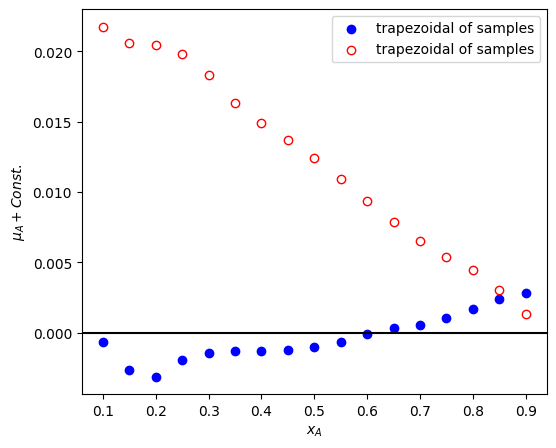

In [27]:

plt.scatter(xlist[:-1], (integral_gp), label="trapezoidal of samples", c="blue")
# plt.plot(x_sample[1:], (integral_sample-integral_sample[0]), c="blue")
# plt.fill_between(x, (lowerb_MCintegral_gp-lowerb_MCintegral_gp[0]), (upperb_MCintegral_gp-upperb_MCintegral_gp[0]), color="blue", alpha=0.2, label="MC of GPR")

plt.scatter(1-xlist[:-1], (integral_gp1), label="trapezoidal of samples", c="w", edgecolors="red")
plt.axhline(0, c="k")
plt.ylabel("$\mu_A+Const.$")
plt.xlabel("$x_A$")
plt.legend()

In [25]:
print("4040K to kJ/mol:", 4040./298.*2.074)
print("4040K to eV:", 4040./300.*0.0259)

4040K to kJ/mol: 28.117315436241608
4040K to eV: 0.3487866666666667
